# Question Answering with NewsQA dataset and BERT-Base

In this notebook i train again bert-base-uncased for qa tasks but this time with the [NewsQA](https://github.com/Maluuba/newsqa) dataset. I use the same model parameters with the SQuAD 2.0 model.

**Note:** due to limitations on the free version of google colab, the experiments on this assignment were executed on [Kaggle](https://www.kaggle.com/).

## First Steps

**GPU Info**

To get the same results you should have a Tesla P100 GPU. This GPU is available for free usage on [Kaggle](https://www.kaggle.com/).

In [ ]:
!nvidia-smi

Wed Mar  9 19:28:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Install pytorch interface for pre-trained BERT**

Then, we will install the interface to use the pre-trained BERT model.

In [ ]:
!pip install transformers

**Import necessary libraries**

Now, it's time to import the necessary libraries for this notebook.

In [ ]:
import torch
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import string
import collections
from transformers import BertTokenizerFast, BertForQuestionAnswering
from transformers.tokenization_utils_base import BatchEncoding
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

pd.set_option('max_colwidth', 500)
%matplotlib inline

**Enable CUDA**

Enable CUDA for GPU utilization by our model. This makes calculations and thus the training of our models faster.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

**Set random seed**

Set a constant random seed in order to get the same (deterministic) outputs every time we run our models.



In [ ]:
seed = 17064
def reset_seed():
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
reset_seed()

**BERT model definition**

And here, we define the name of the pre-trained bert model from [Hugging Face](https://huggingface.co/models) which we'll use.

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased'

## Dataset loading

Now, let's load our datasets:

**Define json preprocessing function**

First, we will define a function that takes a squad json dataset file path as argument and returns a dataframe with the questions, their answers in the form (start_position, end_position, answer_text) and the corpus that contains the answer to the corresponding question.

In [ ]:
def squad_load_from_json(json_file_path: str):
  with open(json_file_path, "r") as f:
    json_data = json.load(f)['data']
    questions = []
    answers = []
    corpuses = []
    for category in json_data:
      for paragraph in category['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
          corpuses.append(context)
          question = qa['question']
          questions.append(question)
          if qa['is_impossible']:
            ans_list = qa['plausible_answers']
          else:
            ans_list = qa['answers']
          ans_set = set()
          for idx, ans in enumerate(ans_list):
            ans_set.add((ans['answer_start'], ans['answer_start']+len(ans['text']), ans['text']))
          answers.append(list(ans_set))
    return pd.DataFrame(data={'question':questions, 'answer':answers, 'corpus':corpuses})

Then, we will load the datasets converted to SQuAD json format.

**Train Dataset**

In [ ]:
train_dataset = squad_load_from_json("../input/newsqa-squad-format/newsqa_train.json")
train_dataset

,question,answer,corpus
0,What was the amount of children murdered ?,"[(305, 307, 19)]","NEW DELHI , India -LRB- CNN -RRB- -- A high court in northern India on Friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed `` the house of horrors . '' Moninder Singh Pandher was sentenced to death by a lower court in February . The teen was one of 19 victims -- children and young women -- in one of the most gruesome serial killings in India in recent years . The Allahabad high court has acquitted Moninder Singh Pandher , his lawyer Sik..."
1,Where was one employee killed ?,"[(44, 69, Sudanese region of Darfur)]","-LRB- CNN -RRB- -- Fighting in the volatile Sudanese region of Darfur has sparked another wave of refugees into Chad and left a Red Cross employee dead , according to international agencies . Refugee camps in eastern Chad house about 300,000 people who fled violence in the Darfur region of Sudan . The U.N. High Commissioner for Refugees said on Monday that more than 12,000 people have fled militia attacks over the last few days from Sudan 's Darfur region to neighboring Chad , still recoveri..."
2,who did say South Africa did not issue a visa on time ?,"[(114, 137, Archbishop Desmond Tutu)]","Johannesburg -LRB- CNN -RRB- -- Miffed by a visa delay that led the Dalai Lama to cancel a trip to South Africa , Archbishop Desmond Tutu lashed out at his government Tuesday , saying it had acted worse than apartheid regimes and had forgotten all that the nation stood for . `` When we used to apply for passports under the apartheid government , we never knew until the last moment what their decision was , '' Tutu said at a news conference . `` Our government is worse than the apartheid gove..."
3,How many years old was the businessman ?,"[(540, 551, 29-year-old)]",-LRB- CNN -RRB- -- England international footballer Steven Gerrard was found not guilty of affray by a court in his home city on Friday . England international Steven Gerrard was cleared by a court in Liverpool of affray . The jury at Liverpool Crown Court took a little over an hour to clear Gerrard of charges relating to a fracas in a nightclub bar in the north-western of England city on December 29 of last year . They accepted the Liverpool captain 's version that he acted in self defense ...
4,What frightened the families ?,"[(697, 798, a series of killings and threats by Muslim extremists ordering them to convert to Islam or face death)]","BAGHDAD , Iraq -LRB- CNN -RRB- -- At least 6,000 Christians have fled the northern Iraqi city of Mosul in the past week because of killings and death threats , Iraq 's Ministry of Immigration and Displaced Persons said Thursday . A Christian family that fled Mosul found refuge in the Al-Sayida monastery about 30 miles north of the city . The number represents 1,424 families , at least 70 more families than were reported to be displaced on Wednesday . The ministry said it had set up an operat..."
...,...,...,...
92544,what does Soufan 's book argue against ?,"[(2769, 2899, Bush administration 's assertion that waterboarding and other harsh tactics was their best option with several al Qaeda operatives)]","CNN -LRB- CNN -RRB- -- The FBI interrogator who bluffed al Qaeda detainees into giving up significant intelligence began his career in an unusual way . Ali Soufan 's fraternity brothers bet him that the agency would never hire a guy like him . A Lebanese-born American studying international relations at a Pennsylvania college , Soufan had just returned to his frat house after talking with a school official about what he should do with his life . It was 1994 . His buddies gave him some good-n..."
92545,what is this pattern is all about ?,"[(1715, 1922, The basic plot begins with a happy family situation . Then one extremely curious or transgressive child goes out on his or her own . And , no matter how ` bad ' the child has been , he gets to come back home)]","-LRB- CNN -RRB- -- They fea

**Validation Dataset**

In [ ]:
validation_dataset = squad_load_from_json("../input/newsqa-squad-format/newsqa_dev.json")
validation_dataset

,question,answer,corpus
0,Iran criticizes who ?,"[(75, 108, U.S. President-elect Barack Obama)]","TEHRAN , Iran -LRB- CNN -RRB- -- Iran 's parliament speaker has criticized U.S. President-elect Barack Obama for saying that Iran 's development of a nuclear weapon is unacceptable . Iranian President Mahmoud Ahmadinejad has outlined where he thinks U.S. policy needs to change . Ali Larijani said Saturday that Obama should apply his campaign message of change to U.S. dealings with Iran . `` Obama must know that the change that he talks about is not simply a superficial changing of colors or ..."
1,What happened to the U.N. compound ?,"[(3246, 3265, hit and set on fire)]","LONDON , England -LRB- CNN -RRB- -- Israeli military action in Gaza is comparable to that of German soldiers during the Holocaust , a Jewish UK lawmaker whose family suffered at the hands of the Nazis has claimed . A protester confronts police in London last weekend at a demonstration against Israeli action in Gaza . Gerald Kaufman , a member of the UK 's ruling Labour Party , also called for an arms embargo on Israel , currently fighting militant Palestinian group Hamas , during the debate ..."
2,Who said there is no immediate plans for deployment ?,"[(122, 137, President Obama)]","WASHINGTON -LRB- CNN -RRB- -- There are no immediate plans to commit more U.S. troops to the ongoing war in Afghanistan , President Obama said Wednesday . Canadian Prime Minister Stephen Harper , left , and President Obama meet in Washington on Wednesday . Speaking to reporters alongside Canadian Prime Minister Stephen Harper , Obama said he would consult with U.S. allies before determining a strategy in Afghanistan after last month 's elections there . `` I 'm going to take a very deliberat..."
3,Will Lieberman investigate further ?,"[(1980, 2005, intends to follow up with)]","LOS ANGELES , California -LRB- CNN -RRB- -- Former detainees of Immigration and Customs Enforcement accuse the agency in a lawsuit of forcibly injecting them with psychotropic drugs while trying to shuttle them out of the country during their deportation . Raymond Soeoth , pictured here with his wife , says he was injected with drugs by ICE agents against his will . One of the drugs in question is the potent anti-psychotic drug Haldol , which is often used to treat schizophrenia or other men..."
4,Who spent nine years in prison ?,"[(112, 123, Tim Masters)]","-LRB- CNN -RRB- -- A Colorado prosecutor Friday asked a judge to dismiss the first-degree murder charge against Tim Masters , who spent nine years in prison until new DNA evidence indicated someone else might have committed the crime . Tim Masters , center , walks out of a Fort Collins , Colorado , courthouse Tuesday with his attorney David Wymore . Court papers filed by District Attorney Larry Abrahamson cited `` newly discovered '' evidence , but took pains to state that evidence did n't c..."
...,...,...,...
5161,What is the top drug choice in Hong Kong ?,"[(141, 149, ketamine)]","HONG KONG , China -LRB- CNN -RRB- -- A 16-year-old Hong Kong boy makes two phone calls for delivery : One for pizza , the other for the drug ketamine . Two teenage girls are found semi-conscious in a car park after overdosing on ketamine . A 13-year-old boy joins a gang and is given free ketamine . Glass capsules containing ketamine , which has become the drug of choice for Hong Kong 's youth . These are anecdotes told to CNN by police , a family doctor and a former gang member . Ketamine ha..."
5162,What was the name of the agency ?,"[(332, 339, Mohmand)]","ISLAMABAD , Pakistan -LRB- CNN -RRB- -- Hundreds of militants , believed to be foreign fighters , launched attacks on various military check posts in Pakistan 's border with Afghanistan Saturday night and early Sunday morning , military officials said . A Pakistan soldier on patrol last fall against militants on the border of the Mohmand agency district . The ensuing fighting left 40 militants and six Pakistan soldiers dead

**Exploding datasets on multiple answers**

Now, we will explode the datasets on the answers list field because it will help later.


In [ ]:
train_dataset = train_dataset.explode('answer').reset_index()
train_dataset

,index,question,answer,corpus
0,0,What was the amount of children murdered ?,"(305, 307, 19)","NEW DELHI , India -LRB- CNN -RRB- -- A high court in northern India on Friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed `` the house of horrors . '' Moninder Singh Pandher was sentenced to death by a lower court in February . The teen was one of 19 victims -- children and young women -- in one of the most gruesome serial killings in India in recent years . The Allahabad high court has acquitted Moninder Singh Pandher , his lawyer Sik..."
1,1,Where was one employee killed ?,"(44, 69, Sudanese region of Darfur)","-LRB- CNN -RRB- -- Fighting in the volatile Sudanese region of Darfur has sparked another wave of refugees into Chad and left a Red Cross employee dead , according to international agencies . Refugee camps in eastern Chad house about 300,000 people who fled violence in the Darfur region of Sudan . The U.N. High Commissioner for Refugees said on Monday that more than 12,000 people have fled militia attacks over the last few days from Sudan 's Darfur region to neighboring Chad , still recoveri..."
2,2,who did say South Africa did not issue a visa on time ?,"(114, 137, Archbishop Desmond Tutu)","Johannesburg -LRB- CNN -RRB- -- Miffed by a visa delay that led the Dalai Lama to cancel a trip to South Africa , Archbishop Desmond Tutu lashed out at his government Tuesday , saying it had acted worse than apartheid regimes and had forgotten all that the nation stood for . `` When we used to apply for passports under the apartheid government , we never knew until the last moment what their decision was , '' Tutu said at a news conference . `` Our government is worse than the apartheid gove..."
3,3,How many years old was the businessman ?,"(540, 551, 29-year-old)",-LRB- CNN -RRB- -- England international footballer Steven Gerrard was found not guilty of affray by a court in his home city on Friday . England international Steven Gerrard was cleared by a court in Liverpool of affray . The jury at Liverpool Crown Court took a little over an hour to clear Gerrard of charges relating to a fracas in a nightclub bar in the north-western of England city on December 29 of last year . They accepted the Liverpool captain 's version that he acted in self defense ...
4,4,What frightened the families ?,"(697, 798, a series of killings and threats by Muslim extremists ordering them to convert to Islam or face death)","BAGHDAD , Iraq -LRB- CNN -RRB- -- At least 6,000 Christians have fled the northern Iraqi city of Mosul in the past week because of killings and death threats , Iraq 's Ministry of Immigration and Displaced Persons said Thursday . A Christian family that fled Mosul found refuge in the Al-Sayida monastery about 30 miles north of the city . The number represents 1,424 families , at least 70 more families than were reported to be displaced on Wednesday . The ministry said it had set up an operat..."
...,...,...,...,...
92544,92544,what does Soufan 's book argue against ?,"(2769, 2899, Bush administration 's assertion that waterboarding and other harsh tactics was their best option with several al Qaeda operatives)","CNN -LRB- CNN -RRB- -- The FBI interrogator who bluffed al Qaeda detainees into giving up significant intelligence began his career in an unusual way . Ali Soufan 's fraternity brothers bet him that the agency would never hire a guy like him . A Lebanese-born American studying international relations at a Pennsylvania college , Soufan had just returned to his frat house after talking with a school official about what he should do with his life . It was 1994 . His buddies gave him some good-n..."
92545,92545,what is this pattern is all about ?,"(1715, 1922, The basic plot begins with a happy family situation . Then one extremely curious or transgressive child goes out on his or her own . And , no matter how ` bad ' the child has been , he gets to come back home)","-LRB- CNN

In [ ]:
validation_dataset = validation_dataset.explode('answer').reset_index()
validation_dataset

,index,question,answer,corpus
0,0,Iran criticizes who ?,"(75, 108, U.S. President-elect Barack Obama)","TEHRAN , Iran -LRB- CNN -RRB- -- Iran 's parliament speaker has criticized U.S. President-elect Barack Obama for saying that Iran 's development of a nuclear weapon is unacceptable . Iranian President Mahmoud Ahmadinejad has outlined where he thinks U.S. policy needs to change . Ali Larijani said Saturday that Obama should apply his campaign message of change to U.S. dealings with Iran . `` Obama must know that the change that he talks about is not simply a superficial changing of colors or ..."
1,1,What happened to the U.N. compound ?,"(3246, 3265, hit and set on fire)","LONDON , England -LRB- CNN -RRB- -- Israeli military action in Gaza is comparable to that of German soldiers during the Holocaust , a Jewish UK lawmaker whose family suffered at the hands of the Nazis has claimed . A protester confronts police in London last weekend at a demonstration against Israeli action in Gaza . Gerald Kaufman , a member of the UK 's ruling Labour Party , also called for an arms embargo on Israel , currently fighting militant Palestinian group Hamas , during the debate ..."
2,2,Who said there is no immediate plans for deployment ?,"(122, 137, President Obama)","WASHINGTON -LRB- CNN -RRB- -- There are no immediate plans to commit more U.S. troops to the ongoing war in Afghanistan , President Obama said Wednesday . Canadian Prime Minister Stephen Harper , left , and President Obama meet in Washington on Wednesday . Speaking to reporters alongside Canadian Prime Minister Stephen Harper , Obama said he would consult with U.S. allies before determining a strategy in Afghanistan after last month 's elections there . `` I 'm going to take a very deliberat..."
3,3,Will Lieberman investigate further ?,"(1980, 2005, intends to follow up with)","LOS ANGELES , California -LRB- CNN -RRB- -- Former detainees of Immigration and Customs Enforcement accuse the agency in a lawsuit of forcibly injecting them with psychotropic drugs while trying to shuttle them out of the country during their deportation . Raymond Soeoth , pictured here with his wife , says he was injected with drugs by ICE agents against his will . One of the drugs in question is the potent anti-psychotic drug Haldol , which is often used to treat schizophrenia or other men..."
4,4,Who spent nine years in prison ?,"(112, 123, Tim Masters)","-LRB- CNN -RRB- -- A Colorado prosecutor Friday asked a judge to dismiss the first-degree murder charge against Tim Masters , who spent nine years in prison until new DNA evidence indicated someone else might have committed the crime . Tim Masters , center , walks out of a Fort Collins , Colorado , courthouse Tuesday with his attorney David Wymore . Court papers filed by District Attorney Larry Abrahamson cited `` newly discovered '' evidence , but took pains to state that evidence did n't c..."
...,...,...,...,...
5161,5161,What is the top drug choice in Hong Kong ?,"(141, 149, ketamine)","HONG KONG , China -LRB- CNN -RRB- -- A 16-year-old Hong Kong boy makes two phone calls for delivery : One for pizza , the other for the drug ketamine . Two teenage girls are found semi-conscious in a car park after overdosing on ketamine . A 13-year-old boy joins a gang and is given free ketamine . Glass capsules containing ketamine , which has become the drug of choice for Hong Kong 's youth . These are anecdotes told to CNN by police , a family doctor and a former gang member . Ketamine ha..."
5162,5162,What was the name of the agency ?,"(332, 339, Mohmand)","ISLAMABAD , Pakistan -LRB- CNN -RRB- -- Hundreds of militants , believed to be foreign fighters , launched attacks on various military check posts in Pakistan 's border with Afghanistan Saturday night and early Sunday morning , military officials said . A Pakistan soldier on patrol last fall against militants on the border of the Mohmand agency district . The ensuing fighting left 40 militants and six Pakist

**Download BERT tokenizer**

After loading the datasets, before we use them for the evaluation process, we must first tokenize them to calculate the gold answer start and end token positions.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Calculate start and end tokens of the answers**

In [ ]:
def calculate_tokenized_ans_indices(dataset: pd.DataFrame):
  ans_tok_start = []
  ans_tok_end = []
  ans_tok_text = []
  for idx, ans in enumerate(dataset['answer'].values):
    if not pd.isna(ans):
      ans_text_start = ans[0]
      ans_text_end = ans[1]
      ans_text = ans[2]
      encoding = tokenizer.encode_plus(text=dataset['corpus'].values[idx], text_pair=dataset['question'].values[idx], max_length=512, padding='max_length', truncation=True)
      ans_start = encoding.char_to_token(0, ans_text_start)
      ans_end = encoding.char_to_token(0, ans_text_end-1)
      # Τruncated answer
      if ans_start is None:
        ans_start = ans_end = tokenizer.model_max_length
      elif ans_end is None:
        ans_end = [i for i, inp in enumerate(encoding['input_ids']) if inp == tokenizer.sep_token_id][0]
      # else:
      ans_text_tok = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoding['input_ids'][ans_start:ans_end+1]))
      #   if (normalize_answer(ans_text) != normalize_answer(ans_tok_text)):
      #     print(idx, normalize_answer(ans_text), "|||||", normalize_answer(ans_tok_text))
    else:
      ans_start = ans_end = tokenizer.model_max_length
      ans_text_tok = ""
    ans_tok_start.append(ans_start)
    ans_tok_end.append(ans_end)
    ans_tok_text.append(ans_text_tok)
  dataset['ans_start_tok'] = ans_tok_start
  dataset['ans_end_tok'] = ans_tok_end
  dataset['ans_tok_text'] = ans_tok_text
  return dataset

In [ ]:
train_dataset = calculate_tokenized_ans_indices(train_dataset)
train_dataset

,index,question,answer,corpus,ans_start_tok,ans_end_tok,ans_tok_text
0,0,What was the amount of children murdered ?,"(305, 307, 19)","NEW DELHI , India -LRB- CNN -RRB- -- A high court in northern India on Friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed `` the house of horrors . '' Moninder Singh Pandher was sentenced to death by a lower court in February . The teen was one of 19 victims -- children and young women -- in one of the most gruesome serial killings in India in recent years . The Allahabad high court has acquitted Moninder Singh Pandher , his lawyer Sik...",74,74,19
1,1,Where was one employee killed ?,"(44, 69, Sudanese region of Darfur)","-LRB- CNN -RRB- -- Fighting in the volatile Sudanese region of Darfur has sparked another wave of refugees into Chad and left a Red Cross employee dead , according to international agencies . Refugee camps in eastern Chad house about 300,000 people who fled violence in the Darfur region of Sudan . The U.N. High Commissioner for Refugees said on Monday that more than 12,000 people have fled militia attacks over the last few days from Sudan 's Darfur region to neighboring Chad , still recoveri...",16,20,sudanese region of darfur
2,2,who did say South Africa did not issue a visa on time ?,"(114, 137, Archbishop Desmond Tutu)","Johannesburg -LRB- CNN -RRB- -- Miffed by a visa delay that led the Dalai Lama to cancel a trip to South Africa , Archbishop Desmond Tutu lashed out at his government Tuesday , saying it had acted worse than apartheid regimes and had forgotten all that the nation stood for . `` When we used to apply for passports under the apartheid government , we never knew until the last moment what their decision was , '' Tutu said at a news conference . `` Our government is worse than the apartheid gove...",32,35,archbishop desmond tutu
3,3,How many years old was the businessman ?,"(540, 551, 29-year-old)",-LRB- CNN -RRB- -- England international footballer Steven Gerrard was found not guilty of affray by a court in his home city on Friday . England international Steven Gerrard was cleared by a court in Liverpool of affray . The jury at Liverpool Crown Court took a little over an hour to clear Gerrard of charges relating to a fracas in a nightclub bar in the north-western of England city on December 29 of last year . They accepted the Liverpool captain 's version that he acted in self defense ...,118,122,29 - year - old
4,4,What frightened the families ?,"(697, 798, a series of killings and threats by Muslim extremists ordering them to convert to Islam or face death)","BAGHDAD , Iraq -LRB- CNN -RRB- -- At least 6,000 Christians have fled the northern Iraqi city of Mosul in the past week because of killings and death threats , Iraq 's Ministry of Immigration and Displaced Persons said Thursday . A Christian family that fled Mosul found refuge in the Al-Sayida monastery about 30 miles north of the city . The number represents 1,424 families , at least 70 more families than were reported to be displaced on Wednesday . The ministry said it had set up an operat...",146,166,a series of killings and threats by muslim extremists ordering them to convert to islam or face death
...,...,...,...,...,...,...,...
92544,92544,what does Soufan 's book argue against ?,"(2769, 2899, Bush administration 's assertion that waterboarding and other harsh tactics was their best option with several al Qaeda operatives)","CNN -LRB- CNN -RRB- -- The FBI interrogator who bluffed al Qaeda detainees into giving up significant intelligence began his career in an unusual way . Ali Soufan 's fraternity brothers bet him that the agency would never hire a guy like him . A Lebanese-born American studying international relations at a Pennsylvania college , Soufan had just returned to his frat house after talking with a school official about what he should do with his life . It was 1994 . His buddies gave him some good-n...",512,512,
92545,92545,what 

In [ ]:
validation_dataset = calculate_tokenized_ans_indices(validation_dataset)
validation_dataset

,index,question,answer,corpus,ans_start_tok,ans_end_tok,ans_tok_text
0,0,Iran criticizes who ?,"(75, 108, U.S. President-elect Barack Obama)","TEHRAN , Iran -LRB- CNN -RRB- -- Iran 's parliament speaker has criticized U.S. President-elect Barack Obama for saying that Iran 's development of a nuclear weapon is unacceptable . Iranian President Mahmoud Ahmadinejad has outlined where he thinks U.S. policy needs to change . Ali Larijani said Saturday that Obama should apply his campaign message of change to U.S. dealings with Iran . `` Obama must know that the change that he talks about is not simply a superficial changing of colors or ...",22,30,u. s. president - elect barack obama
1,1,What happened to the U.N. compound ?,"(3246, 3265, hit and set on fire)","LONDON , England -LRB- CNN -RRB- -- Israeli military action in Gaza is comparable to that of German soldiers during the Holocaust , a Jewish UK lawmaker whose family suffered at the hands of the Nazis has claimed . A protester confronts police in London last weekend at a demonstration against Israeli action in Gaza . Gerald Kaufman , a member of the UK 's ruling Labour Party , also called for an arms embargo on Israel , currently fighting militant Palestinian group Hamas , during the debate ...",512,512,
2,2,Who said there is no immediate plans for deployment ?,"(122, 137, President Obama)","WASHINGTON -LRB- CNN -RRB- -- There are no immediate plans to commit more U.S. troops to the ongoing war in Afghanistan , President Obama said Wednesday . Canadian Prime Minister Stephen Harper , left , and President Obama meet in Washington on Wednesday . Speaking to reporters alongside Canadian Prime Minister Stephen Harper , Obama said he would consult with U.S. allies before determining a strategy in Afghanistan after last month 's elections there . `` I 'm going to take a very deliberat...",33,34,president obama
3,3,Will Lieberman investigate further ?,"(1980, 2005, intends to follow up with)","LOS ANGELES , California -LRB- CNN -RRB- -- Former detainees of Immigration and Customs Enforcement accuse the agency in a lawsuit of forcibly injecting them with psychotropic drugs while trying to shuttle them out of the country during their deportation . Raymond Soeoth , pictured here with his wife , says he was injected with drugs by ICE agents against his will . One of the drugs in question is the potent anti-psychotic drug Haldol , which is often used to treat schizophrenia or other men...",404,408,intends to follow up with
4,4,Who spent nine years in prison ?,"(112, 123, Tim Masters)","-LRB- CNN -RRB- -- A Colorado prosecutor Friday asked a judge to dismiss the first-degree murder charge against Tim Masters , who spent nine years in prison until new DNA evidence indicated someone else might have committed the crime . Tim Masters , center , walks out of a Fort Collins , Colorado , courthouse Tuesday with his attorney David Wymore . Court papers filed by District Attorney Larry Abrahamson cited `` newly discovered '' evidence , but took pains to state that evidence did n't c...",28,29,tim masters
...,...,...,...,...,...,...,...
5161,5161,What is the top drug choice in Hong Kong ?,"(141, 149, ketamine)","HONG KONG , China -LRB- CNN -RRB- -- A 16-year-old Hong Kong boy makes two phone calls for delivery : One for pizza , the other for the drug ketamine . Two teenage girls are found semi-conscious in a car park after overdosing on ketamine . A 13-year-old boy joins a gang and is given free ketamine . Glass capsules containing ketamine , which has become the drug of choice for Hong Kong 's youth . These are anecdotes told to CNN by police , a family doctor and a former gang member . Ketamine ha...",41,43,ketamine
5162,5162,What was the name of the agency ?,"(332, 339, Mohmand)","ISLAMABAD , Pakistan -LRB- CNN -RRB- -- Hundreds of militants , believed to be foreign fighters , launched attacks on various military check posts in Pakistan 's border with Afghanistan Saturday night and early Sunday m

**Create custom dataset class**

Now let's create the custom dataset class which also handle the tokenization part. This way, the tokenization happens during training and validation and we don't consume ram to save all the tokenizations in prior.


In [ ]:
class NewsQA_Dataset(Dataset):
  def __init__(self, data: pd.DataFrame):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    encoding = tokenizer(text=self.data['corpus'].values[idx], text_pair=self.data['question'].values[idx], max_length=512, padding='max_length', truncation=True, return_tensors='pt').to(device)
    return {
        'ans_start_tok': torch.tensor(self.data['ans_start_tok'].values[idx], dtype=torch.long, device=device),
        'ans_end_tok': torch.tensor(self.data['ans_end_tok'].values[idx], dtype=torch.long, device=device),
        'input_ids': encoding['input_ids'][0], 
        'attention_mask': encoding['attention_mask'][0],
        'token_type_ids': encoding['token_type_ids'][0]
    }

In [ ]:
train_squad_dataset = NewsQA_Dataset(data=train_dataset)

In [ ]:
val_squad_dataset = NewsQA_Dataset(data=validation_dataset)

**Create Dataloaders**

In [ ]:
BATCH_SIZE=8

In [ ]:
train_dataloader = DataLoader(train_squad_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
validation_dataloader = DataLoader(val_squad_dataset, batch_size=1, shuffle=False)

On the validation dataloader, i gave 1 as batch size and i'll explain why beyond.

**Train & Evaluation methods**

Now, let's define the training function. It follows the same logic as the previous ones. The only major difference is the way the validation loss is calculated. In particular, for each question in the validation dataset, i take the minimum loss among all the answers because the model's goal is to approach any valid answer as good as possible, and if i consider all answer losses (and even those from answers far from the one that gives the minimum loss), this will add extra noisy error for no reason and confuse the train-validation loss plot. To calculate the validation loss this way, we must take the answers one at a time, so this is the reason i set batch size=1 on the validation dataloader.

In [ ]:
def train(model: BertForQuestionAnswering, train_dataloader: DataLoader, validation_dataloader: DataLoader, learning_rate: float, epochs: int):
  # Define the optimizer
  opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
  # Initialize train and validation losses lists
  train_losses = []
  validation_losses = []
  # Train for given # of epochs
  for epoch in range(epochs):
    model.train()
    t_losses = []
    for batch in tqdm(train_dataloader):
      # Delete previously stored gradients
      opt.zero_grad()
      # Get loss and outputs from the model
      start_positions = batch['ans_start_tok'] # we can do this because we know taht squad trai dataset questions always have 1 question
      end_positions = batch['ans_end_tok']
      out = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], token_type_ids=batch['token_type_ids'], start_positions=start_positions, end_positions=end_positions)
      # Perform backpropagation starting from the loss returned in this epoch
      loss = out[0]
      loss.backward()
      # Update model's weights based on the gradients calculated during backprop
      opt.step()
      t_losses.append(loss.item())

    # Calculate train loss in current epoch
    train_loss = np.mean(t_losses) 
    train_losses.append(train_loss)
    with torch.no_grad():
      model.eval()
      v_losses = []
      tmp_losses = []
      cur_idx = -1
      for val_idx, val_batch in enumerate(tqdm(validation_dataloader)):
        start_positions = val_batch['ans_start_tok'] # we can do this because we know taht squad trai dataset questions always have 1 question
        end_positions = val_batch['ans_end_tok']
        out = model(input_ids=val_batch['input_ids'], attention_mask=val_batch['attention_mask'], token_type_ids=val_batch['token_type_ids'], start_positions=start_positions, end_positions=end_positions)
        loss = out[0]
        batch_idx = validation_dataset['index'].values[val_idx]
        if cur_idx != batch_idx:
          cur_idx = batch_idx
          if len(tmp_losses) > 0:
            v_losses.append(min(tmp_losses))
          tmp_losses = []
        tmp_losses.append(loss.item())
      if len(tmp_losses) > 0:
        v_losses.append(min(tmp_losses))
      val_loss = np.mean(v_losses) 
      validation_losses.append(val_loss)

    # Print current epoch status
    print(f"Epoch {epoch:3}: Loss = {train_loss:.5f} Val_loss = {val_loss:.5f}")

  return train_losses, validation_losses

And let's also define a function to plot the train and validation losses.

In [ ]:
def plot_loss_vs_epochs(train_losses, val_losses):
  assert(len(train_losses) == len(val_losses))
  plt.grid()
  plt.plot(list(range(len(train_losses))), train_losses, "o-", label="Train")
  plt.plot(list(range(len(train_losses))), val_losses, "o-", label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

**Model Definition**

Now let's load the pre-trained bert-base-uncased model.

In [ ]:
reset_seed()

In [ ]:
model = BertForQuestionAnswering.from_pretrained(BERT_MODEL_NAME).to(device)
model

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

**Training**

And now, time for training...

In [ ]:
train_losses, validation_losses = train(model, train_dataloader, validation_dataloader, learning_rate=1e-5, epochs=3)

100%|██████████| 5166/5166 [02:06<00:00, 40.94it/s]


Epoch   0: Loss = 2.25142 Val_loss = 1.64339


100%|██████████| 5166/5166 [02:07<00:00, 40.66it/s]


Epoch   1: Loss = 1.60726 Val_loss = 1.60893


100%|██████████| 5166/5166 [02:07<00:00, 40.66it/s]

Epoch   2: Loss = 1.26475 Val_loss = 1.70276


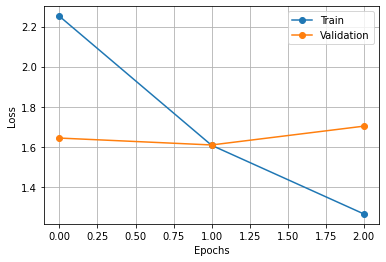

In [ ]:
plot_loss_vs_epochs(train_losses, validation_losses)

**Save the model**

In [ ]:
torch.save(model.state_dict(), "model.pt")